In [ ]:
pip install selenium --user

In [ ]:
pip install webdriver-manager

# Are Korean Products Really Dominating Hong Kong Market?

## 1. Which category has the most Korean products?
category_list = [supermarket, personalcarenhealth, beautynhealth, mothernbaby, pets, gadgetsandelectronics, homenfamily, housewares, deals, sportsntravel, toysnbooks, fashion]

*deals = dining & lifestyle

In [1]:
import time
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

service = executable_path=ChromeDriverManager().install()

[WDM] - Downloading:  92%|█████████▏| 6.04M/6.58M [00:00<00:00, 8.72MB/s]

In [2]:
# Get corresponding URL
## Issue: fixing url to filter country is not working. Need to manipulate selenium to click 'Korea' filter button

def get_driver (category, page):
    if page == '':
        url = 'https://www.hktvmall.com/hktv/en/search_a?keyword=&category={}'.format(category)
    else:
        url = 'https://www.hktvmall.com/hktv/en/search_a?keyword=&category={}&page={}'.format(category, page)
    driver = webdriver.Chrome(service)
    driver.get(url)
    return driver

In [3]:
def count_data (description):
    start = '('
    end = 'items)'
    return int(description[description.find(start)+len(start):description.rfind(end)])

In [4]:
def find_click (driver):
    country_filter = driver.find_element(By.XPATH, "/html/body/div[2]/div[2]/div/div/div/div/div[2]/div/div[2]/div[3]/ul")
    countries = country_filter.text.split("\n")
        
    pos = 0
    for i in countries:
        pos = pos + 1
        if (i == 'Korea') or (i == 'Korean') or (i == 'KOREA') or (i == 'South Korea'):
            pos = str(pos)
            driver.find_element(By.XPATH, "/html/body/div[2]/div[2]/div/div/div/div/div[2]/div/div[2]/div[3]/ul/li[" + pos + "]/label/input").click()
            break

        # Wait until the page is loaded
    pause = WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.CLASS_NAME, "searchFilterContainer_title")))

In [5]:
def get_category_data (category, df_category, idx):
    
    driver = get_driver(category, '')
    html = driver.page_source
    soup = BeautifulSoup(html, "lxml")

    # Count total product
        ## class = sortMenu-pagination
        ## tag = span
    description = driver.find_element(By.CLASS_NAME, "sortMenu-pagination").text.replace(" ", "")
    total_prod_num = count_data(description)
    df_category.loc[idx, ['Total Product']] = total_prod_num

    
    # Count Korean product
        # Find and click Korea in filter
    find_click(driver)
    
        # Count
    description = driver.find_element(By.CLASS_NAME, "sortMenu-pagination").text.replace(" ", "")
    total_ko_prod_num = count_data(description)
    df_category.loc[idx, ['Korean Product']] = total_ko_prod_num
    
    
    # Calculate Percentage
    df_category.loc[idx, ['Percentage(%)']] = round((total_ko_prod_num/total_prod_num)*100, 2)
    
    return

In [ ]:
category_list = ['supermarket', 'personalcarenhealth', 'beautynhealth', 'mothernbaby', 'pets', 'gadgetsandelectronics', 'homenfamily', 'housewares', 'deals', 'sportsntravel', 'toysnbooks', 'fashion']

df_category = pd.DataFrame(columns=['Category','Total Product','Korean Product','Percentage(%)'])


for idx in range(0, len(category_list)):
    category = category_list[idx]
    df_category.loc[idx, ['Category']] = category
    get_category_data(category, df_category, idx)

df_category

In [ ]:
df_category = df_category.sort_values(by=['Percentage(%)'], ascending=False, ignore_index=True)
df_category

In [ ]:
df_category.to_excel("C:/Users/USER/Desktop/Portfolio/HKTVmall/HKTVmall_category_data.xlsx", index=False)

<b> Visualization

In [6]:
df_category = pd.read_excel('C:/Users/USER/Desktop/Portfolio/HKTVmall/HKTVmall_category_data.xlsx')

[WDM] - Downloading: 100%|██████████| 6.58M/6.58M [00:03<00:00, 2.02MB/s]


Text(0.5, 1.0, 'Percentage of Korean Products by Category')

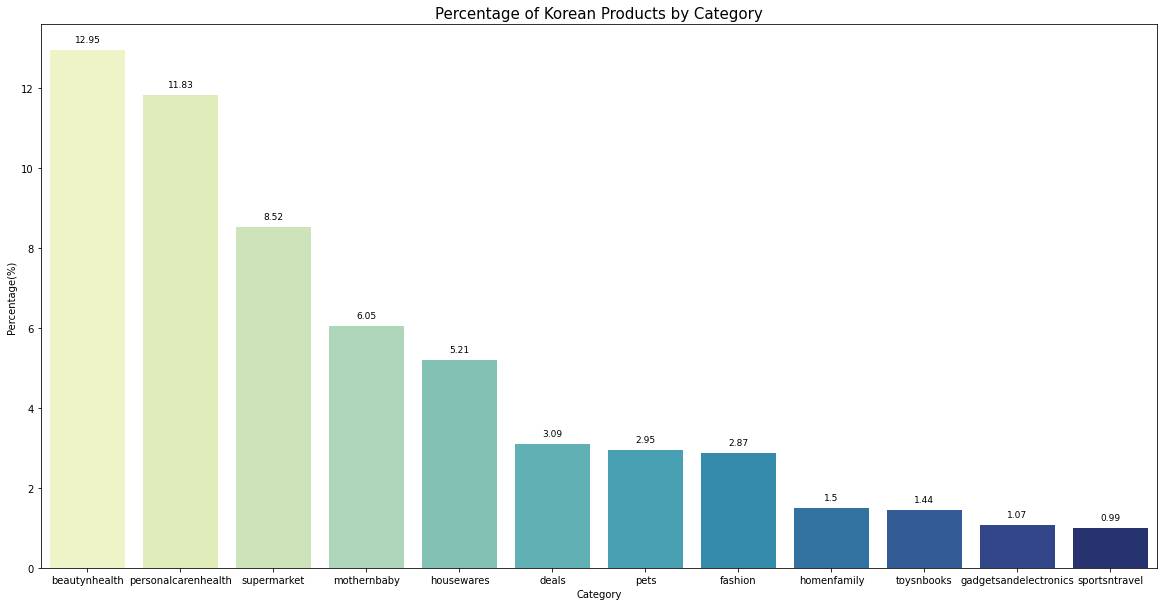

In [7]:
plt.figure (figsize = (20, 10))

ax = sns.barplot(x = df_category['Category'], y = df_category['Percentage(%)'], data = df_category, palette = 'YlGnBu')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.2, height, ha = 'center', size = 9)

plt.title('Percentage of Korean Products by Category', fontsize = 15)

In [8]:
df_category.head()

,Category,Total Product,Korean Product,Percentage(%)
0,beautynhealth,78467,10165,12.95
1,personalcarenhealth,116929,13831,11.83
2,supermarket,153392,13066,8.52
3,mothernbaby,59154,3577,6.05
4,housewares,68842,3588,5.21


In [9]:
df_category.tail()

,Category,Total Product,Korean Product,Percentage(%)
7,fashion,79077,2272,2.87
8,homenfamily,56709,849,1.50
9,toysnbooks,64984,935,1.44
10,gadgetsandelectronics,96211,1033,1.07
11,sportsntravel,97889,972,0.99


## 2. How Competitive Korean Products Are in HK?

In [10]:
# Get product information
def get_product_info (driver, df_beautyproducts):
    id_list = []
    brand_list = []
    product_list = []
    salesVol_list = []
    price_list = []
    
    html = driver.page_source
    soup = BeautifulSoup(html, "lxml")
    
    # unique id
    ids = driver.find_elements(By.CLASS_NAME, "product-brief")
    for id in ids:
        if id == "": id = 0
        else: id = id.get_attribute("data-id")
        id_list.append(id)
    df_beautyproducts['Id'] = id_list
    
    # brand name and product name
    names = driver.find_elements(By.CLASS_NAME, "brand-product-name")
    for name in names:
        name = name.text
        if name == "": name = 0
        else:
            brandName = name[0:name.find('-')-1]
            productName = name[name.find('-')+2:]
        brand_list.append(brandName)
        product_list.append(productName)
    df_beautyproducts['Brand Name'] = brand_list
    df_beautyproducts['Product Name'] = product_list
    
    # Sales volume
    salesVol = driver.find_elements(By.CLASS_NAME, "salesNumber-container")
    for sales in salesVol:
        sales = sales.text.replace(",", "")
        if sales != "":
            sales = int(sales[0:sales.find('+')-1])
        else:
            sales = int('0')
        salesVol_list.append(sales)
    df_beautyproducts['Sales Volume'] = salesVol_list
    
    # Price
    prices = driver.find_elements(By.CLASS_NAME, "price")
    for price in prices:
        price = float(price.text.replace(" ", "").replace("$", "").replace(",", ""))
        price_list.append(price)
    df_beautyproducts['Price'] = price_list
    
    return df_beautyproducts

In [ ]:
# Find all pages
driver = get_driver('beautynhealth', '')
pages = driver.find_elements(By.CLASS_NAME, "paginationMenu_select")
for page in pages:
    pageCnt = page.text.count('Pages')
pageCnt

In [ ]:
# Iterate all pages
temp = []
for pageNum in range(0, pageCnt):
    driver = get_driver('beautynhealth', pageNum)
    df = pd.DataFrame()
    df = get_product_info(driver, df)
    temp.append(df)

df_beautyproducts = pd.concat(temp)
df_beautyproducts

In [ ]:
df_beautyproducts = df_beautyproducts.sort_values(by=['Sales Volume'], ascending=False, ignore_index=True)
df_beautyproducts.to_excel("C:/Users/USER/Desktop/Portfolio/HKTVmall/HKTVmall_totalBeautyProductsInfo_data.xlsx", index=False)

In [11]:
df_beautyproducts = pd.read_excel("C:/Users/USER/Desktop/Portfolio/HKTVmall/HKTVmall_totalBeautyProductsInfo_data.xlsx")

<b> Check if each product is from Korea or not

In [ ]:
# Click Korean filter
korea_id_list = []

# pageCnt
driver = get_driver('beautynhealth', '')
find_click(driver)
pages = driver.find_element(By.XPATH, "//*[@id='search-result-wrapper']/div/div[3]/div[4]/div/span")
pageCnt_ko = int(pages.text.replace("/", "").replace(" ", "").replace("Pages", "")) 
pageCnt_ko

In [ ]:
driver = get_driver('beautynhealth', '')
# Check Korea filter
find_click(driver)
current_url = driver.current_url

for pageNum in range(0, pageCnt_ko):
    try:
        # Move to next page
        changed_url = current_url + '&page={}'.format(pageNum+1)
        driver.find_element(By.XPATH, "//*[@id='sortMenu_next']").click()
        pause = WebDriverWait(driver, 3).until(EC.url_matches(changed_url))
        ids = driver.find_elements(By.CLASS_NAME, "product-brief")
        for id in ids:
            if id == "": id = 0
            else: id = id.get_attribute("data-id")
            korea_id_list.append(id)
    except:
        pass
        
len(korea_id_list)

In [ ]:
isKorean = []
for total in df_beautyproducts['Id']:
    if total in korea_id_list:
        isKorean.append('Korea')
    else:
        isKorean.append('NonKorea')
        
df_beautyproducts['isKorea'] = isKorean
df_beautyproducts

In [ ]:
# df_beautyproducts = df_beautyproducts.drop('isKorean', axis=1)
# df_beautyproducts
df_beautyproducts.to_excel("C:/Users/USER/Desktop/Portfolio/HKTVmall/HKTVmall_totalBeautyProductsInfo_data.xlsx", index=False)

In [12]:
df_beautyproducts = pd.read_excel("C:/Users/USER/Desktop/Portfolio/HKTVmall/HKTVmall_totalBeautyProductsInfo_data.xlsx")
df_beautyproducts

,Id,Brand Name,Product Name,Sales Volume,Price,isKorea
0,H6167001_S_9348107000488,Eaoron,Hyaluronic Acid Collagen Hydrating Face Mask 2...,10000,48.0,Korea
1,H1053001_S_Soflens-100,Bausch+Lomb,(BC 8.6) Soflens 1Day Contact Lens (P-1.00) (P...,10000,74.0,NonKorea
2,H5711001_S_MoistPI_reg_1day-85-100S,Acuvue,(BC 8.5) Acuvue Moist 1-Day Contact Lens (P -1...,10000,170.0,NonKorea
3,H5711001_S_MoistPI_reg_1day-90-100S,Acuvue,(BC 9.0) Acuvue Moist 1-Day Contact Lens (P -1...,7000,170.0,NonKorea
4,H5711001_S_Biomedics_ex_1day-86-100S,CooperVision,"Biomedics 1 day Extra Contact Lens (BC 8.6, P ...",6000,105.0,NonKorea
...,...,...,...,...,...,...
995,P0088001_S_3614225415012,philosophy,ultimate miracle worker lip serum stick,1,180.0,Korea
996,P0088001_S_3614222736820,philosophy,time in a bottle 100% in-control resist renew ...,0,475.0,Korea
997,P0079001_S_830003A,CANVAS,Aromatic Cell Renewal Oil Set,0,3130.0,Korea
998,P0088001_S_3614224505585,philosophy,amazing grace ballet rose eau de toilette 60ml,0,410.0,Korea


<b> Get Popular Items

In [13]:
df_top_beautyproducts = df_beautyproducts.head(100)
df_top_beautyproducts

,Id,Brand Name,Product Name,Sales Volume,Price,isKorea
0,H6167001_S_9348107000488,Eaoron,Hyaluronic Acid Collagen Hydrating Face Mask 2...,10000,48.0,Korea
1,H1053001_S_Soflens-100,Bausch+Lomb,(BC 8.6) Soflens 1Day Contact Lens (P-1.00) (P...,10000,74.0,NonKorea
2,H5711001_S_MoistPI_reg_1day-85-100S,Acuvue,(BC 8.5) Acuvue Moist 1-Day Contact Lens (P -1...,10000,170.0,NonKorea
3,H5711001_S_MoistPI_reg_1day-90-100S,Acuvue,(BC 9.0) Acuvue Moist 1-Day Contact Lens (P -1...,7000,170.0,NonKorea
4,H5711001_S_Biomedics_ex_1day-86-100S,CooperVision,"Biomedics 1 day Extra Contact Lens (BC 8.6, P ...",6000,105.0,NonKorea
...,...,...,...,...,...,...
95,H0956007_S_LT10008661,moritachicosme,Dispoable Face Towel（80/Sheet）（Parallel Import）,600,49.0,NonKorea
96,H0888001_S_10030252,Gillette,Gillette Menthol Foamy 210g,600,34.9,NonKorea
97,P0038001_S_SD3337875597333,CeraVe,HYDRATING CLEANSER 473ml,600,139.0,NonKorea
98,H5236001_S_CLS-T-86_X3,DR.BSC,【★3pcs★】8X Silk+Hyaluronic Acid Moisturizing T...,600,139.0,Korea


In [14]:
# count Korea product
KoreaBeautyCnt = len(df_top_beautyproducts[df_top_beautyproducts['isKorea']=='Korea'])
KoreaBeautyCnt

28

In [15]:
print('In Beauty category, Korean products take up ' + '{}% of top 100 popular products'.format(round(KoreaBeautyCnt/100 * 100, 2)))

In Beauty category, Korean products take up 28.0% of top 100 popular products


Text(0.5, 1.0, 'Beauty Category: Korea vs Non Korea (Popular Count)')

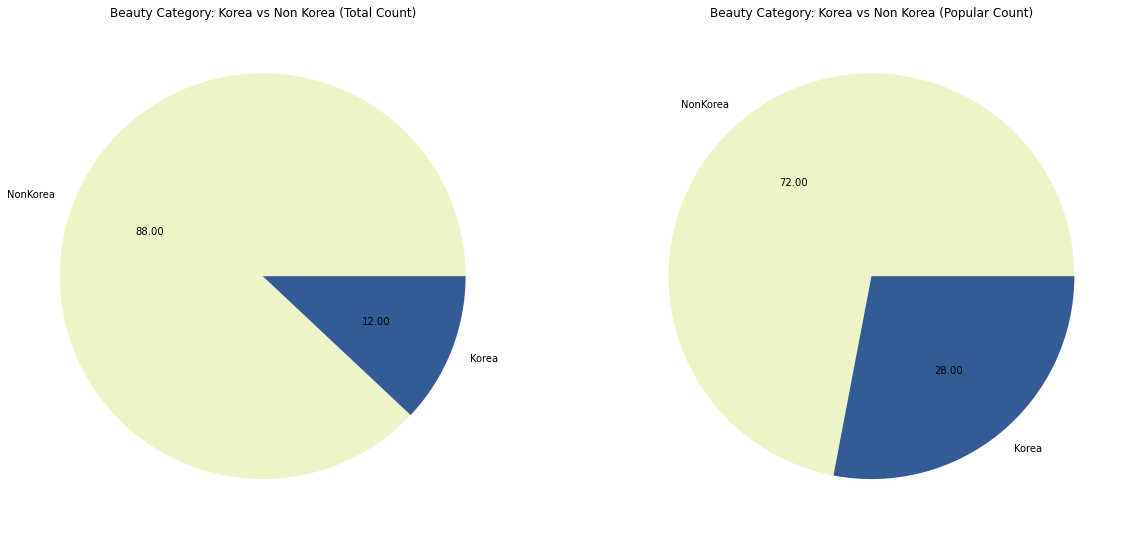

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

colors = colors = ['#eff4c8', '#335b95']

values1 = df_beautyproducts['isKorea'].value_counts()
axs[0].pie(values1, labels = values1.index, autopct = '%.2f', colors = colors)
axs[0].set_title('Beauty Category: Korea vs Non Korea (Total Count)')

values2 = df_top_beautyproducts['isKorea'].value_counts()
axs[1].pie(values2, labels = values2.index, autopct = '%.2f', colors = colors)
axs[1].set_title('Beauty Category: Korea vs Non Korea (Popular Count)')

In [17]:
df_pivot_total = df_beautyproducts.pivot_table(index = 'isKorea', values = 'Sales Volume', aggfunc= 'sum')
total = df_pivot_total['Sales Volume'].sum()
korea = df_pivot_total.iloc[0]['Sales Volume']
nonkorea = df_pivot_total.iloc[1]['Sales Volume']
df_pivot_total['Sales Percentage'] = [round(korea/total*100, 2), round(nonkorea/total*100, 2)]
df_pivot_total

,Sales Volume,Sales Percentage
isKorea,,
Korea,47249,17.23
NonKorea,226971,82.77


In [18]:
df_pivot_popular = df_top_beautyproducts.pivot_table(index = 'isKorea', values = 'Sales Volume', aggfunc= 'sum')
total = df_pivot_popular['Sales Volume'].sum()
korea = df_pivot_popular.iloc[0]['Sales Volume']
nonkorea = df_pivot_popular.iloc[1]['Sales Volume']
df_pivot_popular['Sales Percentage'] = [round(korea/total*100, 2), round(nonkorea/total*100, 2)]
df_pivot_popular

,Sales Volume,Sales Percentage
isKorea,,
Korea,35500,23.76
NonKorea,113900,76.24


Text(0.5, 1.0, 'Beauty Category: Korea vs Non Korea (Popular Sales Volume)')

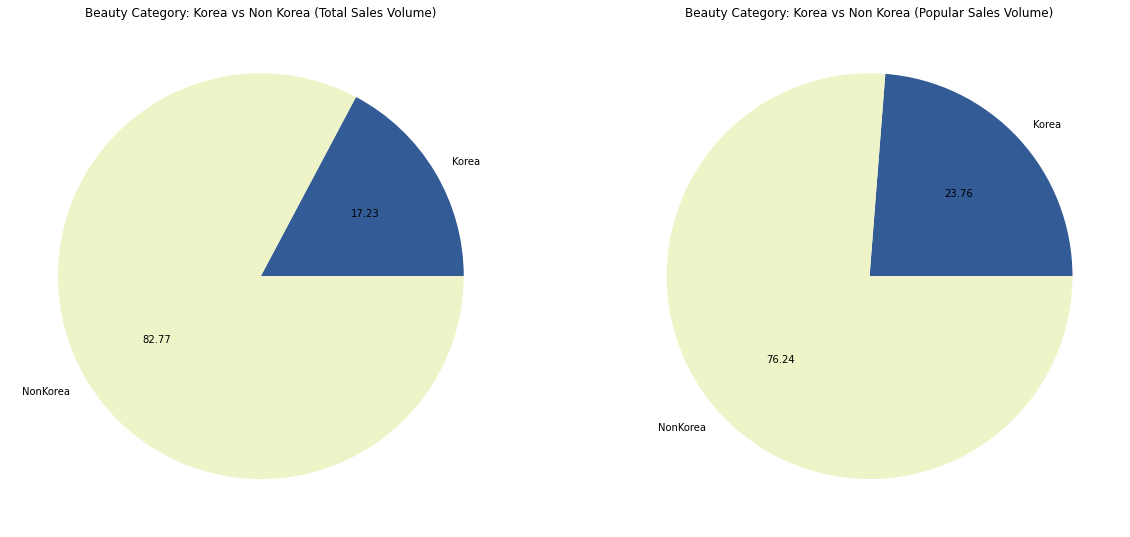

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

colors = colors = ['#335b95', '#eff4c8']

axs[0].pie(df_pivot_total['Sales Volume'], labels = df_pivot_total.index, colors = colors, autopct = '%.2f')
axs[0].set_title('Beauty Category: Korea vs Non Korea (Total Sales Volume)')

axs[1].pie(df_pivot_popular['Sales Volume'], labels = df_pivot_popular.index, colors = colors, autopct = '%.2f')
axs[1].set_title('Beauty Category: Korea vs Non Korea (Popular Sales Volume)')

# Market Positioning

- df_korea: only Korean products in total beauty category
- df_nonkorea: only Non-Korean products in total beauty category

<b> Remove outliers in df_beautyproducts

In [20]:
df_beautyproducts = pd.read_excel("C:/Users/USER/Desktop/Portfolio/HKTVmall/HKTVmall_totalBeautyProductsInfo_data.xlsx")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Price'>

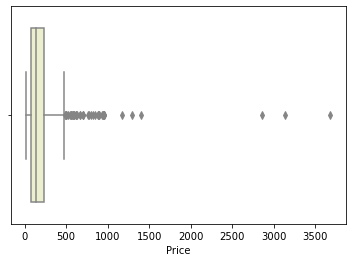

In [21]:
# Remove price outliers in df_beautyproducts
sns.boxplot(df_beautyproducts['Price'], color='#eff4c8')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Price'>

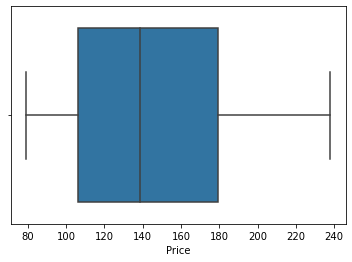

In [22]:
upper_limit = df_beautyproducts['Price'].quantile(0.75)
lower_limit = df_beautyproducts['Price'].quantile(0.25)
df_new_beautyproducts = df_beautyproducts[(df_beautyproducts['Price'] <= upper_limit) & (df_beautyproducts['Price'] >= lower_limit)]
sns.boxplot(df_new_beautyproducts['Price'])

In [23]:
df_new_beautyproducts.shape

(507, 6)

In [24]:
df_new_beautyproducts.to_excel("C:/Users/USER/Desktop/Portfolio/HKTVmall/HKTVmall_totalBeautyProductsInfo_noOutlier_data.xlsx", index=False)

In [25]:
df_new = pd.read_excel("C:/Users/USER/Desktop/Portfolio/HKTVmall/HKTVmall_totalBeautyProductsInfo_noOutlier_data.xlsx")
df_new.head()

,Id,Brand Name,Product Name,Sales Volume,Price,isKorea
0,H5711001_S_MoistPI_reg_1day-85-100S,Acuvue,(BC 8.5) Acuvue Moist 1-Day Contact Lens (P -1...,10000,170.0,NonKorea
1,H5711001_S_MoistPI_reg_1day-90-100S,Acuvue,(BC 9.0) Acuvue Moist 1-Day Contact Lens (P -1...,7000,170.0,NonKorea
2,H5711001_S_Biomedics_ex_1day-86-100S,CooperVision,"Biomedics 1 day Extra Contact Lens (BC 8.6, P ...",6000,105.0,NonKorea
3,H5711001_S_Total1_reg_1day-85-100S,Alcon,DAILIES TOTAL 1 Silicone Hydrogel 1-Day Contac...,4000,205.0,NonKorea
4,H5711001_S_OasysPI_reg_2week-88-100S,Acuvue,(BC 8.8) Acuvue Oasys 2-Week Contact Lens (P -...,4000,180.0,NonKorea


<b> Add Japanese Data

In [26]:
def find_japan_click (driver):
    country_filter = driver.find_element(By.XPATH, "//*[@id='countryOfOrigin-selector']")
    countries = country_filter.text.split("\n")
        
    pos = 0
    for i in countries:
        pos = pos + 1
        if (i == 'Japan') or (i == 'JAPAN') or (i == 'japan'):
            pos = str(pos)
            driver.find_element(By.XPATH, "/html/body/div[2]/div[2]/div/div/div/div/div[2]/div/div[2]/div[3]/ul/li[" + pos + "]/label/input").click()
            break

        # Wait until the page is loaded
    pause = WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.CLASS_NAME, "searchFilterContainer_title")))

In [ ]:
# pageCnt_jp
driver = get_driver('beautynhealth', '')
find_japan_click(driver)
pages = driver.find_element(By.XPATH, "//*[@id='search-result-wrapper']/div/div[3]/div[4]/div/span")
pageCnt_jp = int(pages.text.replace("/", "").replace(" ", "").replace("Pages", "")) 
pageCnt_jp

In [ ]:
driver = get_driver('beautynhealth', '')
# Check Japan filter
find_japan_click(driver)
current_url = driver.current_url
japan_id_list = []

for pageNum in range(0, pageCnt_jp):
    try:
        # Move to next page
        changed_url = current_url + '&page={}'.format(pageNum+1)
        driver.find_element(By.XPATH, "//*[@id='sortMenu_next']").click()
        pause = WebDriverWait(driver, 3).until(EC.url_matches(changed_url))
        ids = driver.find_elements(By.CLASS_NAME, "product-brief")
        for id in ids:
            id = id.get_attribute("data-id")
            japan_id_list.append(id)
    except:
        pass
        
len(japan_id_list)

In [ ]:
isJapan = []
for total in df_new_beautyproducts['Id']:
    if total in japan_id_list:
        isJapan.append('Japan')
    else:
        isJapan.append('NonJapan')
        
df_new['isJapan'] = isJapan
df_new

In [ ]:
len(df_new[df_new["isJapan"] == 'Japan'])

In [ ]:
df_new.to_excel("C:/Users/USER/Desktop/Portfolio/HKTVmall/HKTVmall_totalBeautyProductsInfo_Japan_data.xlsx", index=False)

In [27]:
df_final = pd.read_excel("C:/Users/USER/Desktop/Portfolio/HKTVmall/HKTVmall_totalBeautyProductsInfo_Japan_data.xlsx")
df_final.head()

,Id,Brand Name,Product Name,Sales Volume,Price,isKorea,isJapan
0,H5711001_S_MoistPI_reg_1day-85-100S,Acuvue,(BC 8.5) Acuvue Moist 1-Day Contact Lens (P -1...,10000,170.0,NonKorea,NonJapan
1,H5711001_S_MoistPI_reg_1day-90-100S,Acuvue,(BC 9.0) Acuvue Moist 1-Day Contact Lens (P -1...,7000,170.0,NonKorea,NonJapan
2,H5711001_S_Biomedics_ex_1day-86-100S,CooperVision,"Biomedics 1 day Extra Contact Lens (BC 8.6, P ...",6000,105.0,NonKorea,NonJapan
3,H5711001_S_Total1_reg_1day-85-100S,Alcon,DAILIES TOTAL 1 Silicone Hydrogel 1-Day Contac...,4000,205.0,NonKorea,NonJapan
4,H5711001_S_OasysPI_reg_2week-88-100S,Acuvue,(BC 8.8) Acuvue Oasys 2-Week Contact Lens (P -...,4000,180.0,NonKorea,NonJapan


In [28]:
# Delete error cells (Korea - Japan)
condition = df_final[ (df_final['isKorea'] == 'Korea') & (df_final['isJapan'] == 'Japan') ].index
df_final.drop(condition , inplace=True)
df_final.head(5)

,Id,Brand Name,Product Name,Sales Volume,Price,isKorea,isJapan
0,H5711001_S_MoistPI_reg_1day-85-100S,Acuvue,(BC 8.5) Acuvue Moist 1-Day Contact Lens (P -1...,10000,170.0,NonKorea,NonJapan
1,H5711001_S_MoistPI_reg_1day-90-100S,Acuvue,(BC 9.0) Acuvue Moist 1-Day Contact Lens (P -1...,7000,170.0,NonKorea,NonJapan
2,H5711001_S_Biomedics_ex_1day-86-100S,CooperVision,"Biomedics 1 day Extra Contact Lens (BC 8.6, P ...",6000,105.0,NonKorea,NonJapan
3,H5711001_S_Total1_reg_1day-85-100S,Alcon,DAILIES TOTAL 1 Silicone Hydrogel 1-Day Contac...,4000,205.0,NonKorea,NonJapan
4,H5711001_S_OasysPI_reg_2week-88-100S,Acuvue,(BC 8.8) Acuvue Oasys 2-Week Contact Lens (P -...,4000,180.0,NonKorea,NonJapan


In [29]:
# Japan (total)
condition = (df_final['isJapan'] == 'Japan')
df_japan = df_final[condition]
print('Number of Japanese Products = {}'.format(len(df_japan)))
df_japan.corr()

Number of Japanese Products = 132


,Sales Volume,Price
Sales Volume,1.000000,0.040622
Price,0.040622,1.000000


In [30]:
# Korea (total)
condition = (df_final['isKorea'] == 'Korea')
df_korea = df_final[condition]
print('Number of Korean Products = {}'.format(len(df_korea)))
df_korea.corr()

Number of Korean Products = 57


,Sales Volume,Price
Sales Volume,1.000000,-0.333414
Price,-0.333414,1.000000


In [31]:
df_korea = df_korea.sort_values(by='Sales Volume', ascending = False)
df_korea.head()

,Id,Brand Name,Product Name,Sales Volume,Price,isKorea,isJapan
11,H7988001_S_MV-SMTS001,sMTS,[Official] Korea sMTS Double-Effect Moisturizi...,1000,84.0,Korea,NonJapan
13,H6280001_S_N188SSAB23333,SANS SOUCIS,(New Version)Anti-Blemish Stick 5ml (ref:25391),1000,95.0,Korea,NonJapan
20,S6021001_S_K851939002856B,First Aid Beauty,First Aid Beauty Extreme Repair Cream 170g (in...,900,162.0,Korea,NonJapan
22,H6649001_S_TRHV153,譽・百貨,【Eye bag Saint】Vibrant Glamour crocodile essen...,800,80.0,Korea,NonJapan
29,P0038001_S_SD3337875597227,CeraVe,MOISTURIZING CREAM 340g,600,195.0,Korea,NonJapan


In [32]:
df_japan = df_japan.sort_values(by='Sales Volume', ascending = False)
df_japan.head()

,Id,Brand Name,Product Name,Sales Volume,Price,isKorea,isJapan
7,H0967001_S_10206585A,Fancl,FANCL Mild Cleansing Oil 120ml(TWIN PACK) MCO ...,2000,172.8,NonKorea,Japan
12,H0967001_S_10200041,Ipocare,EX Wart Removing Cream ( 800260)【x1】 Removing ...,1000,85.0,NonKorea,Japan
15,H0967001_S_SD4987241135127,50 Megumi,50惠 Hair Revitalizing Essence (Refill) 150ml (...,1000,197.8,NonKorea,Japan
17,H0967002_S_10205940,Fancl,fancl HTC Deep Charge Collagen 1 Box(10 bottle...,1000,149.8,NonKorea,Japan
18,H0623003_S_168-955,Fancl,MCO Mild Cleansing Oil 120ml (TWIN PACK) 12241...,1000,172.0,NonKorea,Japan


<b> Visualization

In [33]:
# create a list of our conditions
conditions = [
    (df_final['isKorea'] == 'Korea'),
    (df_final['isJapan'] == 'Japan'),
    (df_final['isKorea'] == 'NonKorea') & (df_final['isJapan'] == 'NonJapan')
    ]

values = ['Korea', 'Japan', 'Others']

df_final['Country'] = np.select(conditions, values)
df_final.head()

,Id,Brand Name,Product Name,Sales Volume,Price,isKorea,isJapan,Country
0,H5711001_S_MoistPI_reg_1day-85-100S,Acuvue,(BC 8.5) Acuvue Moist 1-Day Contact Lens (P -1...,10000,170.0,NonKorea,NonJapan,Others
1,H5711001_S_MoistPI_reg_1day-90-100S,Acuvue,(BC 9.0) Acuvue Moist 1-Day Contact Lens (P -1...,7000,170.0,NonKorea,NonJapan,Others
2,H5711001_S_Biomedics_ex_1day-86-100S,CooperVision,"Biomedics 1 day Extra Contact Lens (BC 8.6, P ...",6000,105.0,NonKorea,NonJapan,Others
3,H5711001_S_Total1_reg_1day-85-100S,Alcon,DAILIES TOTAL 1 Silicone Hydrogel 1-Day Contac...,4000,205.0,NonKorea,NonJapan,Others
4,H5711001_S_OasysPI_reg_2week-88-100S,Acuvue,(BC 8.8) Acuvue Oasys 2-Week Contact Lens (P -...,4000,180.0,NonKorea,NonJapan,Others


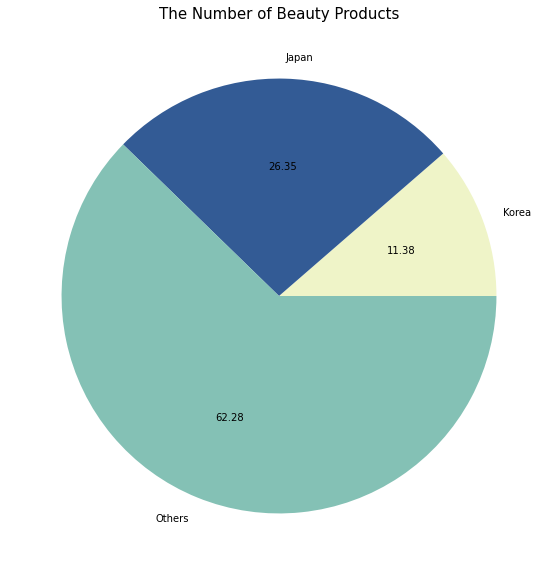

In [35]:
koreaCnt = len(df_final[(df_final['isKorea'] == 'Korea')])
japanCnt = len(df_final[(df_final['isJapan'] == 'Japan')])
others = len(df_final) - koreaCnt - japanCnt

x = np.array([koreaCnt, japanCnt, others])
labels = ["Korea", "Japan", "Others"]

plt.figure (figsize = (20, 10))
colors = ['#eff4c8', '#335b95', '#84c1b5']

plt.pie(x, labels = labels, colors = colors, autopct='%.2f')
plt.title('The Number of Beauty Products', fontsize = 15)
plt.show() 

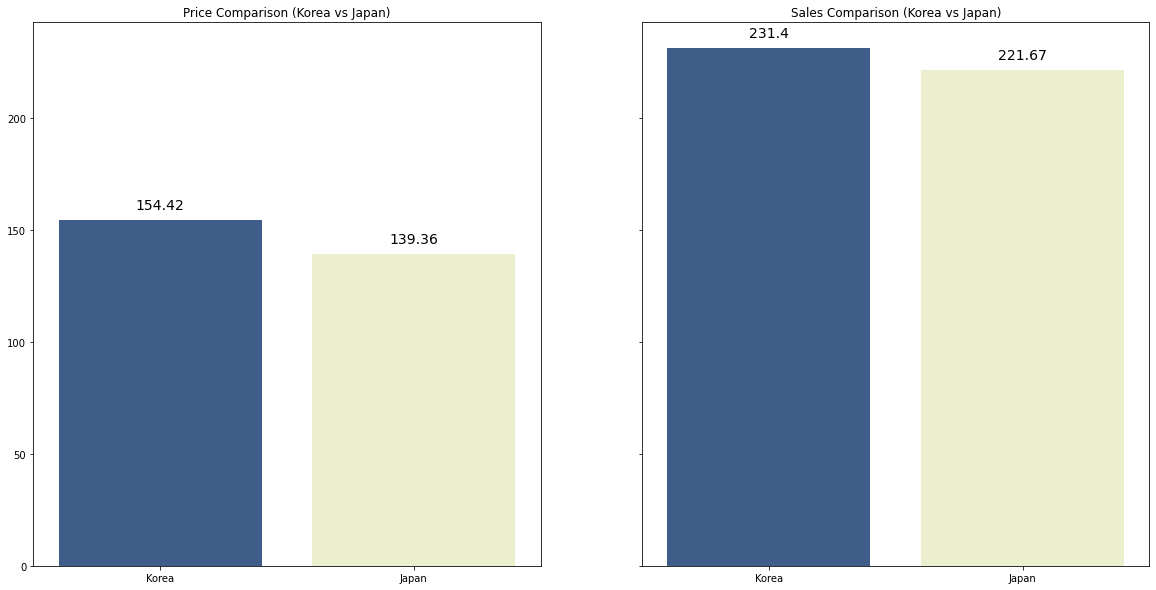

In [36]:
koPrice = round(df_korea['Price'].mean(), 2)
jpPrice = round(df_japan['Price'].mean(), 2)
koSales = round(df_korea['Sales Volume'].mean(), 2)
jpSales = round(df_japan['Sales Volume'].mean(), 2)

colors = ['#335b95', '#eff4c8']
x = ['Korea', 'Japan']
y_price = [koPrice, jpPrice]
y_sales = [koSales, jpSales]

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize = (20, 10))
sns.barplot(x=x, y=y_price, ax = ax1, palette = colors)
ax1.set_title('Price Comparison (Korea vs Japan)')

sns.barplot(x=x, y=y_sales, ax = ax2, palette = colors)
ax2.set_title('Sales Comparison (Korea vs Japan)')

for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width() / 2., height + 5, round(height, 2), ha = 'center', size = 14)

for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width() / 2., height + 5, round(height, 2), ha = 'center', size = 14)

Text(0.5, 1.0, 'Japanese Products')

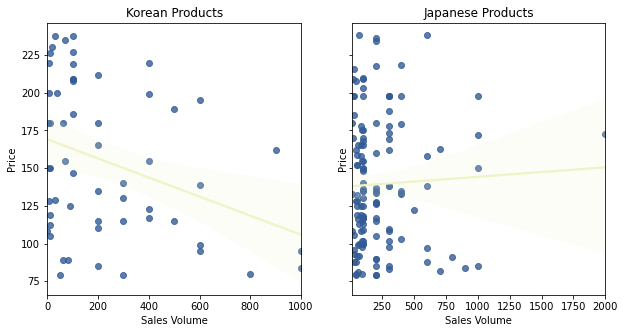

In [37]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize = (10, 5))

sns.regplot(y=df_korea['Price'], x=df_korea['Sales Volume'], scatter_kws={"color": "#335b95"}, line_kws={"color": "#eff4c8"}, ax=ax1)
ax1.set_title('Korean Products')

sns.regplot(y=df_japan['Price'], x=df_japan['Sales Volume'], scatter_kws={"color": "#335b95"}, line_kws={"color": "#eff4c8"}, ax=ax2)
ax2.set_title('Japanese Products')

In [38]:
df_korea.corr()

,Sales Volume,Price
Sales Volume,1.000000,-0.333414
Price,-0.333414,1.000000


In [39]:
df_japan.corr()

,Sales Volume,Price
Sales Volume,1.000000,0.040622
Price,0.040622,1.000000


In [40]:
df_korea['Sales Revenue'] = round(df_korea['Sales Volume'] * df_korea['Price'], 2)
df_korea = df_korea.sort_values(by='Sales Revenue', ascending=False)
df_korea['Sales Revenue'].sum()

1790740.2

In [41]:
df_japan['Sales Revenue'] = round(df_japan['Sales Volume'] * df_japan['Price'], 2)
df_japan = df_japan.sort_values(by='Sales Revenue', ascending=False)
df_japan['Sales Revenue'].sum()

4138920.0

In [42]:
import statistics as stats

In [43]:
print("Standard Deviation of Korea Price is % s "
                % (stats.stdev(df_korea['Price'])))

print("Standard Deviation of Korea Sales Revenue is % s "
                % (stats.stdev(df_korea['Sales Volume'])))

Standard Deviation of Korea Price is 49.96846154448631 
Standard Deviation of Korea Sales Revenue is 263.77742644463416 


In [44]:
print("Standard Deviation of Japan Price is % s "
                % (stats.stdev(df_japan['Price'])))

print("Standard Deviation of Japan Sales Revenue is % s "
                % (stats.stdev(df_japan['Sales Volume'])))

Standard Deviation of Japan Price is 42.13132033869077 
Standard Deviation of Japan Sales Revenue is 272.7976815583542 


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Japanese Product')

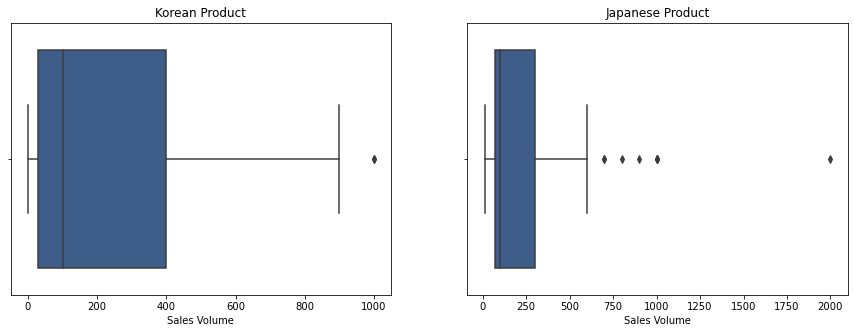

In [45]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize = (15, 5))

sns.boxplot(df_korea['Sales Volume'], color='#335b95', ax=ax1)
ax1.set_title('Korean Product')
sns.boxplot(df_japan['Sales Volume'], color='#335b95', ax=ax2)
ax2.set_title('Japanese Product')